In [1]:
import random
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
print(sc._jsc.sc().getExecutorMemoryStatus())

Map(115.146.84.15:34481 -> (384093388,384093388))


In [3]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

In [4]:
data_list = []

def keywordFilterUDF(n):
    return udf(lambda c: keywordFilter(c,n), BooleanType())

def keywordFilter(x,keywordList):
    if x:
        for Tex in keywordList:
            if Tex.lower() in x.lower():
                return True
            else:
                return False
    else:
        return False

keywordList = ["diabetes","diabetic","type-1 diabetes","T1D","CGM","ADDN","ENDIA",
               "insulin","hbalc","mellitus","blood sugar","basal insulin","insulin pump",
               "kidney","kidney replacement","CSII","DKA","typeonediabetes","t1diabetic",
              "dry mouth","itchy skin","heal slowly","blurred vision","frequent Urination",
               "fatigue","hunger","thirstier","weight loss","hungery","thirsty",""]

In [4]:
tweets = spark.read.json("hdfs://115.146.84.15:9000/patientTL.json")

In [6]:
tweets.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- doc: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- _rev: string (nullable = true)
 |    |-- contributors: string (nullable = true)
 |    |-- coordinates: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- entities: struct (nullable = true)
 |    |    |-- hashtags: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |-- media: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded

In [55]:
FilteredWithKeywords = tweets.filter(keywordFilterUDF(keywordList)(col("doc.text")))

diabetes = FilteredWithKeywords.count()
print diabetes

368


In [69]:
# select_data = FilteredWithKeywords.select("doc.created_at","doc.text","doc.user.screen_name","doc.entities.hashtags").collect()
select_data = FilteredWithKeywords.select("doc.user.screen_name").collect()
# select_data = FilteredWithKeywords.select("doc.created_at","doc.text","doc.entities.hashtags").filter("doc.user.screen_name == 'Sidneiensis'").collect()
print len(select_data)

29965


In [70]:
print select_data[0][0]

Tue Feb 21 01:28:49 +0000 2017


In [71]:
print len(select_data)

29965


In [59]:
from collections import defaultdict
name_dict = defaultdict(int)

In [60]:
for row in select_data:
    name_dict[row[0]] += 1

In [61]:
sortList = sorted(name_dict.iteritems(), key=lambda d:d[1],reverse = True)

In [65]:
sortList[0][0]

u'Sidneiensis'

In [66]:
# import pickle
# import unicodedata
# name_list = []
# for item in sortList:
#     original_text = item[0]
#     processed_text = str(original_text)
#     name_list.append(processed_text) 
    
# with open('name.pickle', 'wb') as handle:
#     pickle.dump(name_list,handle)
    

In [74]:
for row in select_data:
    temp_list = []
    time = row[0]
    text = row[1]
    user_name = row[2]
    temp_list.append(time)
    temp_list.append(text)
    temp_list.append(user_name)
    if row[3] != []:
        hashtag = []
        for tags in row[3]:
            hashtag.append(tags[1])
        temp_list.append(hashtag)
    
    data_list.append(temp_list)

In [75]:
print len(data_list)

29965


In [76]:
import pickle
with open('patientTL.pickle', 'wb') as handle:
    pickle.dump(data_list,handle)

User_timeLine Grab

In [133]:
data_list = []

In [134]:
for nameRow in select_data:
    name = nameRow[0]
    FilteredWithUser = tweets. select("doc.created_at","doc.text","doc.user.screen_name","doc.entities.hashtags").filter(col("doc.user.screen_name") == name).collect()
    for row in FilteredWithUser:
        temp_list = []
        time = row[0]
        text = row[1]
        user_name = row[2]
        temp_list.append(time)
        temp_list.append(text)
        temp_list.append(user_name)
        if row[3] != []:
            hashtag = []
            for tags in row[3]:
                hashtag.append(tags[1])
            temp_list.append(hashtag)

        data_list.append(temp_list)

In [136]:
print len(data_list)

310634


In [137]:
import pickle
with open('tweets2.pickle', 'wb') as handle:
    pickle.dump(data_list,handle)

User_timeLine Analysis

In [73]:
FilteredWithUser = tweets.filter("user.screen_name == 'smoggyAndy'")
number = FilteredWithUser.count()
print number

200


In [74]:
userTL = FilteredWithUser.select("created_at").collect()
# textTL = FilteredWithUser.select("text").collect()

In [75]:
# print userTL[0]
#print textTL[:50]

In [76]:
import pytz
from dateutil import parser
import matplotlib.dates
from pytz import timezone
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np

MelTZ = timezone('Australia/Melbourne')

def MakeTimePlot(TimeInfo):
    EditTime = []
    for time in TimeInfo:
        dayTime = parser.parse(time["created_at"])
        MelTime = dayTime.astimezone(MelTZ)

        EditTime.append(MelTime.hour)

    # the histogram of the data
    n, bins, patches = plt.hist(EditTime, 12, facecolor='b', alpha=0.5)

    plt.xlabel('DayTime')
    plt.ylabel('Tweets')
    plt.title('Tweets TimeSlot')
    plt.axis([0, 24, 0, 40])
    plt.grid(True)

    plt.show()


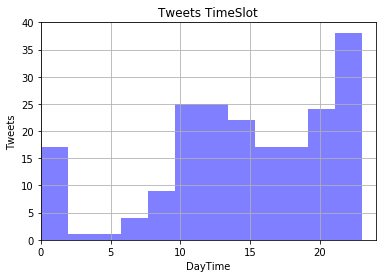

In [77]:
MakeTimePlot(userTL)